In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import random

# Base de dados

In [22]:
df = pd.read_excel('../Base120.xlsx')

In [23]:
def filtra_por_solucao(df, vet_solucao):
    '''Recebe um vetor solução e retorna o df filtrado para essa solução'''
    stand_prescription_map = {i + 1: vet_solucao[i] for i in range(len(vet_solucao))}
    filtered_df = df[df.apply(lambda row: row['prescrição'] == stand_prescription_map.get(row['talhao']), axis=1)]
    return filtered_df

def calcula_volume(result):
	"""
	Calculate the volume by summing specific columns of a DataFrame.
	This function takes a DataFrame `result` and returns the sum of the values
	in columns 3 to 18 (inclusive).
	Parameters:
	result (pandas.DataFrame): The input DataFrame containing the data.
	Returns:
	pandas.Series: A Series containing the sum of the specified columns.
	"""
	
    
	return result.iloc[:, 3:19].sum()

def calcula_penalidade(volume_anual):
    '''retorna penalidade por volume excedente/faltante (R$500)'''
    upper = []
    lower = []
    for v_ano in volume_anual:
        if v_ano < 140000:
            lower.append(np.abs(v_ano - 140000))
        elif v_ano > 160000:
            upper.append(np.abs(v_ano - 160000))
    return np.sum(upper + lower)*500

def calcula_vpl_aux(result, volume_ano):
    '''Calcula o VPL penalizado (função auxiliar)'''
    return np.sum(result['VPL']) - calcula_penalidade(volume_ano)

def plota_volume(df, vet_sol):
    '''Plota o gráfico do volume nos anos'''
    volume_ano = filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()
    (volume_ano/1000).plot(kind='bar')
    plt.hlines(140, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.hlines(160, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.title("Volume de madeira por ano")
    plt.xlabel("Ano de Produção")
    plt.ylabel("Volume (1000 m$^3$)")

def calcula_volume_aux(df, vet_sol):
	"""
	Calculate the auxiliary volume based on the given solution vector.
	This function filters the DataFrame `df` using the solution vector `vet_sol`
	and then sums the values in columns 3 to 18 (inclusive) of the filtered DataFrame.
	Parameters:
	df (pandas.DataFrame): The input DataFrame containing the data.
	vet_sol (list or array-like): The solution vector used to filter the DataFrame.
	Returns:
	pandas.Series: A Series containing the sum of the values in columns 3 to 18 of the filtered DataFrame.
	"""
    
	return filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()

def calcula_vpl_total(df, vet_solucao):
    '''Calcula o VPL total penalizado'''
    result = filtra_por_solucao(df, vet_solucao)
    volume_ano = calcula_volume(result)
    return calcula_vpl_aux(result, volume_ano)

def encontra_pior_ano(df, sol):
    volume_ano = calcula_volume_aux(df, sol)
    return np.argmax(np.abs(volume_ano-160000)) + 1

def numpy_to_python(obj):
    '''Converte np.int e np.float para int e float dos dados do dicionário'''
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    
def python_to_numpy(dicionario):
    '''Converte int e float para np.int e np.float dos dados do dicionário'''
    for chave, subdict in dicionario.items():
        for subchave, valor in subdict.items():
            if isinstance(valor, int):
                subdict[subchave] = np.int64(valor)
            elif isinstance(valor, float):
                subdict[subchave] = np.float64(valor)
                
    dicionario = {np.int64(key): valor for key, valor in dicionario.items()}
    return dicionario

---

## Alteração na base de dados

In [24]:
df_2 = df.drop_duplicates(subset=['talhao'] + df.columns[3:].tolist(), keep='first')
df_2.to_csv('../base_reduzida.csv', index=False)

---

# Algoritmo Genético

## Soluções importadas


In [25]:
with open("../solucoes_alpha.json", "r") as arquivo: # soluções geradas por heurística construtiva
    solucoes_alpha = json.load(arquivo)
solucoes_alpha = [np.array(sol) for sol in solucoes_alpha]

In [26]:
class solucao:
    def __init__(self, sol):
        self.sol = sol
        self.vpl = calcula_vpl_total(df_2, self.sol)
        global count_func_obj
        count_func_obj += 1
    
    def recalcula_vpl(self):
        self.vpl = calcula_vpl_total(df_2, self.sol)
        global count_func_obj
        count_func_obj += 1

In [45]:
import numpy as np
import random

def set_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)

def gera_populacao_inicial(n_pop, n_talhoes=120, perc_aleatoria=0.8) -> list[solucao]:
    
    populacao = [solucao(sol) for sol in np.random.randint(1, 121, size=(round(n_pop*perc_aleatoria), n_talhoes))]  # pop aleatória
    melhor_sol = solucoes_alpha[0]
    
    global melhor_global
    melhor_global = solucao(melhor_sol)
    
    for _ in range(n_pop-round(n_pop*perc_aleatoria)): # quantidade soluções semi boas
        sol = np.copy(melhor_sol)
        random.shuffle(sol)
        populacao.append(solucao(sol))
    return populacao

def selecao(populacao, metodo='torneio') -> np.ndarray[solucao]:
    
    pares = np.array([[],[]])
    tam_torneio = 0.15

    for _ in range(round(len(populacao) / 2)): # quantidade de pares
        populacao_aux = populacao.copy()
        pop_torneio1 = random.sample(populacao_aux, round(len(populacao_aux) * tam_torneio))
        p1 = max(pop_torneio1, key=lambda sol_torneio: sol_torneio.vpl)
        populacao_aux.remove(p1)
        
        pop_torneio2 = random.sample(populacao_aux, round(len(populacao_aux) * tam_torneio))
        p2 = max(pop_torneio2, key=lambda sol_torneio: sol_torneio.vpl)
        pares = np.append(pares, [[p1], [p2]])
        
    return pares.reshape(round(len(populacao)/2), 2)

def recombinacao(pares, prob_mutacao) -> list[solucao]:
    
    global melhor_global
    filhos = []
    pontos_crossover = [round(len(pares[0][0].sol) * random.random()) for _ in range(2)]
    pontos_crossover.sort()
    crossover1 = pontos_crossover[0]
    crossover2 = pontos_crossover[1]
    
    for pai1, pai2 in pares:
        filho1 = solucao(np.concatenate((pai1.sol[:crossover1], 
                                         pai2.sol[crossover1:crossover2], 
                                         pai1.sol[crossover2:])))
        
        filho2 = solucao(np.concatenate((pai2.sol[:crossover1], 
                                         pai1.sol[crossover1:crossover2], 
                                         pai2.sol[crossover2:])))
        
        if random.random() < prob_mutacao:
            mutacao(filho1)
        if random.random() < prob_mutacao:
            mutacao(filho2)
            
        melhor_global = max(filho1, filho2, melhor_global, key=lambda aux: aux.vpl) # atualiza melhor_solucao
        filhos.append(filho1)
        filhos.append(filho2)
    return filhos
    
def mutacao(filho) -> None:
    talhao_sorteado = random.randrange(1, 121)
    presc_sorteada = random.choice(df_2[df_2['talhao'] == (talhao_sorteado)]['prescrição'].unique())
    filho.sol[talhao_sorteado-1] = presc_sorteada
    filho.recalcula_vpl()

def substituicao(pais, filhos, prop_elite=0.2) -> list[solucao]:
    ''' Mantem prop_elite% dos melhores pais mais o restante dos filhos aleatórios '''
    
    n_elite = int(prop_elite * len(pais))
    pais_elite = pais.copy()
    pais_elite.sort(key=lambda sol_torneio: sol_torneio.vpl, reverse=True)
    return pais_elite[:n_elite] + random.sample(filhos, len(pais) - n_elite)

def calcula_estatisticas(populacao, estatisticas) -> dict:
    lista_vpl = [sol.vpl for sol in populacao]
    estatisticas['media'].append(np.mean(lista_vpl))
    estatisticas['std'].append(np.std(lista_vpl))
    estatisticas['max'].append(np.max(lista_vpl))
    estatisticas['min'].append(np.min(lista_vpl))


In [ ]:
[np.int64(-202586846), np.int64(-199376239), np.int64(-250197205)]

In [88]:
a = []

set_seed(41)
for _ in range(4): # num de experimentos
    melhor_global = None
    count_func_obj = 0
    estatisticas = {'media':[], 'std':[], 'max':[], 'min':[]} # estatísticas da população
    populacao = gera_populacao_inicial(20) # pais
    
    # while count_func_obj < 500:
    for _ in range(50): # num de gerações
        calcula_estatisticas(populacao, estatisticas)
        pares = selecao(populacao)
        filhos = recombinacao(pares, prob_mutacao=0.05)
        populacao = substituicao(populacao, filhos, prop_elite=0.2)
    a.append(melhor_global.vpl)
    
# print(melhor_global.vpl)
print(a)

[np.int64(-202586846), np.int64(-199376239), np.int64(-250197205), np.int64(-249336340)]


In [75]:
print(count_func_obj)
print(estatisticas['std'])

503
[np.float64(217448661.19400078), np.float64(217992658.15211242), np.float64(132181806.1630694), np.float64(36725263.89106944), np.float64(27460767.312750947), np.float64(20223342.437070455), np.float64(15465316.597951755), np.float64(20820262.985259064), np.float64(13882189.166493192), np.float64(4601369.622701983), np.float64(1165856.2500093225), np.float64(1148094.2598210045), np.float64(391549.2127958471), np.float64(786829.6446074891), np.float64(950367.9253089248), np.float64(2311714.543838929), np.float64(391549.21279584704), np.float64(0.0), np.float64(3408.658973848807), np.float64(0.0), np.float64(555868.5877750244), np.float64(1970185.5149913798), np.float64(4076039.1387753696)]


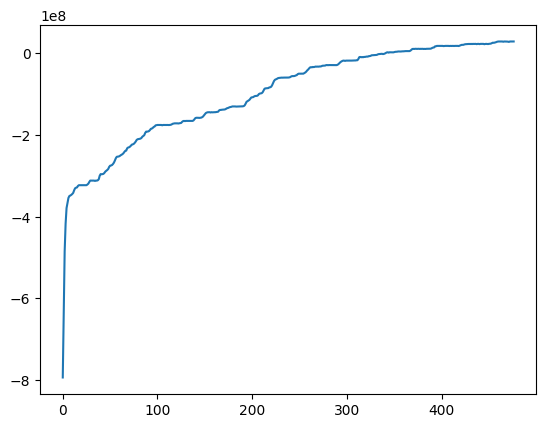

In [31]:
plt.plot(estatisticas['media'])